## 1.1 Beelden

*  dataset (MIT-license):
https://public.roboflow.com/object-detection/self-driving-car/3/download/yolov8
Cars are probably the lines that start with 1
https://public.roboflow.com/object-detection/self-driving-car
*  dataset-overview:
https://www.cityscapes-dataset.com/dataset-overview/
*  connecteren Google Drive met collab:
zie https://www.youtube.com/watch?v=8HvugBq5NKg
*  onderstaande code gaat uit van 2 folders die deze dataset bevatten: all_images en all_labels

In [23]:
#Definiëren van de sample size en de grootte van de uiteindelijke dataset
#dataset is kleiner omdat we de images die trucks bevatten (zoals gedetecteerd via de predict functie uit Yolo) uitzuiveren
sample_size = 10000
total_images_dataset = 3024

In [24]:
import os
#Declareren waar de images en labels van de Cityscapes dataset staan (na upload van deze images en labels naar Google Drive)
source_folder_labels = "./labels"
source_folder_images = "./images"

#Declareren van de folders die in de notebook gebruikt en automatisch aangemaakt worden
sample_folder = "./sampleSize"
sample_folder_size = sample_folder + str(sample_size)
sample_folder_predict = os.path.join(sample_folder_size, "Yolo_output","predict","labels")
sample_folder_size_images = os.path.join(sample_folder_size, "images")
sample_folder_size_labels = os.path.join(sample_folder_size, "labels")
training_sets_folder = os.path.join(sample_folder_size, "training_sets")
bounding_box_folder = os.path.join(sample_folder_size, "images_bounding_boxes")

In [25]:
#tellen aantal beelden in de dataset
import os
all_images = [f for f in os.listdir(source_folder_images)]
print("totaal aantal beelden in de folder geupload in google drive:", len(all_images))
all_labels = [f for f in os.listdir(source_folder_labels)]
print("totaal aantal labels in de folder geupload in google drive:", len(all_labels))

totaal aantal beelden in de folder geupload in google drive: 29800
totaal aantal labels in de folder geupload in google drive: 29800


### 1.1.1 Beelden samplen

In [26]:
#functie definitie
#input: sample_size
#returns 2 folders (labels en images) in de sample_size folder
import os
import random
import shutil

def select_random_txt_files(num_files):
    # Create destination folders if it doesn't exist
    if not os.path.exists(sample_folder_size_images):
        os.makedirs(sample_folder_size_images)
    if not os.path.exists(sample_folder_size_labels):
        os.makedirs(sample_folder_size_labels)

    # Get list of all files in the source image folder
    all_images = [f for f in os.listdir(source_folder_images)]

    # Select random images
    random_images = random.sample(all_images, num_files)

    # Get list of all TXT files in the source folder
    all_txt_files = [f for f in os.listdir(source_folder_labels)]

    # Select random TXT files with the same name as the randomly selected images
    random_txt_files = []
    random_images_files = []
    for image_name in random_images:
        txt_file_with_same_name = [txt for txt in all_txt_files if os.path.splitext(txt)[0] == os.path.splitext(image_name)[0]]
        if txt_file_with_same_name:
            random_txt_files.append(txt_file_with_same_name[0])
            random_images_files.append(image_name)

    # Copy selected TXT files to destination folder
    for txt_file in random_txt_files:
        source_path = os.path.join(source_folder_labels, txt_file)
        dest_path_labels = os.path.join(sample_folder_size_labels, txt_file)
        shutil.copyfile(source_path, dest_path_labels)

    # Copy selected images files to destination folder (last copy fails ==> Bug in Google Drive???)
    for image_file in random_images_files:
        source_path = os.path.join(source_folder_images, image_file)
        dest_path_images = os.path.join(sample_folder_size_images, image_file)
        shutil.copyfile(source_path, dest_path_images)

In [ ]:
# Call the function to select and copy random files
select_random_txt_files(sample_size)

In [ ]:
#controle op aangemaakte sample
all_images = [f for f in os.listdir(sample_folder_size_images)]
print("aantal beelden in de sample folder:", len(all_images))
all_labels = [f for f in os.listdir(sample_folder_size_labels)]
print("aantal labels in de sample folder:", len(all_labels))

1.1.2 Beelden uitzuiveren

In [ ]:
#elk beeld in de sample verwerken met predict functie van Yolov8 zodat we een label-file hebben
# wegschrijven resultaten in de sample_size folder onder Yolo_output/predict/labels
from IPython import display
display.clear_output()

import ultralytics
import os
ultralytics.checks()

from ultralytics import YOLO

from IPython.display import display, Image
model = YOLO('yolov8n.pt')
model.names

# inhoud results zie https://docs.ultralytics.com/reference/engine/results/#ultralytics.engine.results.BaseTensor.to
if not os.path.exists(sample_folder_predict):
  os.makedirs(sample_folder_predict)
model.predict(source = os.path.join(sample_folder_size, "images"), save_txt = True, exist_ok=True, project=os.path.join(sample_folder_size, "Yolo_output"))

In [30]:
#controle
predict_labels = [f for f in os.listdir(sample_folder_predict)]
print(sample_folder_predict)
print("aantal labels in de predict folder:", len(predict_labels))

./sampleSize10000\Yolo_output\predict\labels
aantal labels in de predict folder: 0


In [31]:
#beelden en labels weggooien uit de sampleSize folder als ze geen auto's bevatten
import os
import random

# Get list of all label files in the predict folder
truth_txt_files = [f for f in os.listdir(sample_folder_size_labels)]

# Select random TXT files with the same name as the randomly selected images
labels_containing_cars = []
for label_file in truth_txt_files:
  with open(os.path.join(sample_folder_size_labels, label_file), 'r') as f:
    lines = f.readlines()
    for line in lines:
        class_id, _, _, _, _ = map(float, line.strip().split())
        if class_id == 1:
          labels_containing_cars.append(label_file)
          break

print("aantal beelden met auto's: ", len(labels_containing_cars))

# Remove elements
truth_txt_files_filtered = [file for file in truth_txt_files if file not in labels_containing_cars]
print("aantal beelden zonder auto's: ", len(truth_txt_files_filtered))

for label_file_without_car in truth_txt_files_filtered:
    if os.path.exists(os.path.join(sample_folder_size_labels, label_file_without_car)):
        os.remove(os.path.join(sample_folder_size_labels, label_file_without_car))
    else:
      print("no label file in sample folder")
    if os.path.exists(os.path.join(sample_folder_predict, label_file_without_car)):
        os.remove(os.path.join(sample_folder_predict, label_file_without_car))
    else:
      print("no label file in predict folder")
    image_file = os.path.splitext(label_file_without_car)[0] + ".jpg"
    if os.path.exists(os.path.join(sample_folder_size_images, image_file)):
       os.remove(os.path.join(sample_folder_size_images, image_file))
    else:
      print("no image file in sample folder")


#controle op aangemaakte sample
all_images = [f for f in os.listdir(sample_folder_size_images)]
print("aantal beelden in de sample folder:", len(all_images))
all_labels = [f for f in os.listdir(sample_folder_size_labels)]
print("aantal labels in de sample folder:", len(all_labels))
predict_labels = [f for f in os.listdir(sample_folder_predict)]
print("aantal labels in de predict folder:", len(predict_labels))

aantal beelden met auto's:  8656
aantal beelden zonder auto's:  1344
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no 

no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label

no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label

no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label file in predict folder
no label

In [32]:
#beelden weggooien uit de sampleSize folder als ze trucks bevatten volgens Yolov8 en reduceren naar 504 stuks in totaal
import os
import random

# Get list of all label files in the predict folder
predict_txt_files = [f for f in os.listdir(sample_folder_predict)]

# Select random TXT files with the same name as the randomly selected images
labels_containing_trucks = []
for label_file in predict_txt_files:
  with open(os.path.join(sample_folder_predict, label_file), 'r') as f:
    lines = f.readlines()
    for line in lines:
        class_id, _, _, _, _ = map(float, line.strip().split())
        if class_id == 7:
          labels_containing_trucks.append(label_file)
          break

print("aantal beelden met trucks: ", len(labels_containing_trucks))

if len(predict_txt_files) - len(labels_containing_trucks) > total_images_dataset:
  for label_file_with_truck in labels_containing_trucks:
    if os.path.exists(os.path.join(sample_folder_size_labels, label_file_with_truck)):
        os.remove(os.path.join(sample_folder_size_labels, label_file_with_truck))
    else:
      print("no label file in sample folder")
    if os.path.exists(os.path.join(sample_folder_predict, label_file_with_truck)):
        os.remove(os.path.join(sample_folder_predict, label_file_with_truck))
    else:
      print("no label file in predict folder")
    image_file = os.path.splitext(label_file_with_truck)[0] + ".jpg"
    if os.path.exists(os.path.join(sample_folder_size_images, image_file)):
       os.remove(os.path.join(sample_folder_size_images, image_file))
    else:
      print("no image file in sample folder")
else:
  print("er zijn niet genoeg files beschikbaar. Selecteer een grotere sample size in 1.1, delete de folder sampleSizeXXX in je drive en laat alles opnieuw draaien")

#resterende files wegdoen zodat we op het aantal stuks uitkomen in de variabele total_images_dataset
all_files = os.listdir(sample_folder_size_labels)
total_files = len(all_files)

if total_files <= total_images_dataset:
   print("geen bestanden te verwijderen. Al minder dan of gelijk aan de total_images_dataset variabele. Selecteer een grotere sample size in 1.1, delete de folder sampleSizeXXX in je drive en laat alles opnieuw draaien")

# Calculate the number of files to delete
files_to_delete_count = total_files - total_images_dataset

# Randomly select files to delete
files_to_delete = random.sample(all_files, files_to_delete_count)

# Remove selected files
for file_name in files_to_delete:
    os.remove(os.path.join(sample_folder_size_labels, file_name))
    image_file = os.path.splitext(file_name)[0] + ".jpg"
    if os.path.exists(os.path.join(sample_folder_size_images, image_file)):
      os.remove(os.path.join(sample_folder_size_images, image_file))
    if os.path.exists(os.path.join(sample_folder_predict, file_name)):
      os.remove(os.path.join(sample_folder_predict, file_name))

aantal beelden met trucks:  0
er zijn niet genoeg files beschikbaar. Selecteer een grotere sample size in 1.1, delete de folder sampleSizeXXX in je drive en laat alles opnieuw draaien


In [33]:
#controle
all_images = [f for f in os.listdir(sample_folder_size_images)]
print("aantal beelden in de sample folder:", len(all_images))
truth_labels = [f for f in os.listdir(sample_folder_size_labels)]
print(sample_folder_size_labels)
print("aantal labels in de sample folder:", len(truth_labels))
predict_labels = [f for f in os.listdir(sample_folder_predict)]
print("aantal labels in de predict folder:", len(predict_labels))

aantal beelden in de sample folder: 3024
./sampleSize10000\labels
aantal labels in de sample folder: 3024
aantal labels in de predict folder: 0


In [34]:
# adjusting the truth labels to match the class IDs used by the pretrained YOLO model ==> change ClassId from 1 to 2
# only keeping truth label for cars

import os

print(sample_folder_size_labels)

# Get list of all label files in the predict folder
truth_txt_files = [f for f in os.listdir(sample_folder_size_labels)]

# Function to update class IDs
def update_class_ids(label_file):
    updated_lines = []
    with open(label_file, 'r') as file:
        lines = file.readlines()
        for line in lines:
            parts = line.strip().split()
            class_id = int(parts[0])
            if class_id == 1:
                parts[0] = '2'  # Update class_id from 1 to 2
                updated_lines.append(' '.join(parts) + '\n')

    with open(label_file, 'w') as file:
        file.writelines(updated_lines)

# Process all label files in the directory
for label_file in truth_txt_files:
    file_path = os.path.join(sample_folder_size_labels, label_file)
    update_class_ids(file_path)

./sampleSize10000\labels


1.1.3 Beelden verrijken met bounding boxes

In [35]:
#Tonen van bounding boxes rond de auto's op 1 willekeurig gekozen image
#vervangen door https://stackoverflow.com/questions/23720875/opencv-draw-a-rectangle-around-a-region
import cv2
import random
from PIL import Image, ImageDraw

# Load the image
file_name = random.choice(os.listdir(sample_folder_predict))
image = Image.open(os.path.join(sample_folder_size_images, os.path.splitext(file_name)[0] + ".jpg"))
draw = ImageDraw.Draw(image)

print(file_name)
# Load corresponding truth-label file
with open(os.path.join(sample_folder_size_labels, file_name), 'r') as f:
    lines = f.readlines()
print(sample_folder_size_labels)
    
# Parse bounding box data and draw on the image
print("code vanuit truth labels-file")
for line in lines:
    print(line)
    class_id, x_center, y_center, width, height = map(float, line.strip().split())
    #class id 1 are cars,
    if class_id == 2:
        width *= image.width
        height *= image.height
        x_center *= image.width
        y_center *= image.height
        x_min = x_center - width / 2
        y_min = y_center - height / 2
        x_max = x_center + width / 2
        y_max = y_center + height / 2

        # Draw bounding box on the image
        draw.rectangle([x_min, y_min, x_max, y_max], outline="red")

print ("")
# Load corresponding predict-label file
with open(os.path.join(sample_folder_predict, file_name), 'r') as f:
    lines = f.readlines()

# Read label file and draw bounding boxes
print("code vanuit predict labels-file")
for line in lines:
  print(line)
  class_id, x_center, y_center, width, height = map(float, line.strip().split())
  if class_id == 2:
      width *= image.width
      height *= image.height
      x_center *= image.width
      y_center *= image.height
      x_min = x_center - width / 2
      y_min = y_center - height / 2
      x_max = x_center + width / 2
      y_max = y_center + height / 2

      # Draw bounding box on the image
      draw.rectangle([x_min, y_min, x_max, y_max], outline="yellow")
# Show the image with bounding boxes
print("truth box rood")
print("predict box geel")
display(image)

IndexError: Cannot choose from an empty sequence

In [ ]:
#alle beelden van de sample overlopen en truth- en predict-bounding boxes erop tekenen (rond auto's zijnde class id = 1 (truth) en 2 (predict))
#Bounding box tonen rond de auto's voor de beide label-files: truth box rood, predict box geel
#saven in bounding_box_folder
import os
import cv2

def draw_bounding_boxes(image, labels, classes, kleur):
    global imagebb
    for label in labels:
        class_id, x_center, y_center, width, height = label
        if class_id in classes:
          width *= 518
          height *= 518
          x_center *= 518
          y_center *= 518
          x_min = int(x_center - width / 2)
          y_min = int(y_center - height / 2)
          x_max = int(x_center + width / 2)
          y_max = int(y_center + height / 2)

          # Draw bounding box on the image using OpenCV
          imagebb = cv2.rectangle(image, (x_min, y_min), (x_max, y_max), kleur)

if not os.path.exists(bounding_box_folder):
   os.makedirs(bounding_box_folder)

#truth bounding boxes aanbrengen
image_files_truth = os.listdir(sample_folder_size_images)

for image_file in image_files_truth:
   truth_labels = []
   image = cv2.imread(os.path.join(sample_folder_size_images, image_file))
   label_path_truth = os.path.join(sample_folder_size_labels, f"{os.path.splitext(image_file)[0]}.txt")
   with open(label_path_truth, 'r') as file:
            truth_labels.extend(list(map(float, line.strip().split())) for line in file)
   draw_bounding_boxes(image, truth_labels, [2], (0, 0, 255))
   cv2.imwrite(os.path.join(bounding_box_folder, f"{os.path.splitext(image_file)[0]}.jpg"), image)

#predict bounding boxes aanbrengen

image_files_bounding = os.listdir(bounding_box_folder)

for image_file in image_files_bounding:
   predict_labels = []
   image = cv2.imread(os.path.join(bounding_box_folder, image_file))
   label_path_predict = os.path.join(sample_folder_predict, os.path.splitext(image_file)[0] + ".txt")
   if os.path.exists(label_path_predict):
      with open(label_path_predict, 'r') as file:
                predict_labels.extend(list(map(float, line.strip().split())) for line in file)
      draw_bounding_boxes(image, predict_labels, [2], (0, 255, 255))
      cv2.imwrite(os.path.join(bounding_box_folder, f"{os.path.splitext(image_file)[0]}.jpg"), image)

In [ ]:
#controle
print("Number of images in the sample_folder_size_images folder:", len(os.listdir(sample_folder_size_images)))
print("Number of images in the bounding box folder:", len(os.listdir(bounding_box_folder)))

## 1.2 Augmentation (schemering aanbrengen)

**TODO: beslissen over augmentatiecriteria**


general guidelines and starting points for adjusting brightness and contrast to simulate twilight conditions:

*   Reduce Overall Brightness: Twilight scenes are typically dimmer compared to
daylight scenes. You can achieve this by reducing the overall brightness of the image.

*   Adjust Contrast: In twilight conditions, the contrast between highlights and shadows tends to be lower compared to daylight. You can decrease the contrast to create a softer, more subdued appearance.

### 1.2.1 Schemering aanbrengen met OpenCV

In [ ]:
#basic example using OpenCV to adjust the brightness and contrast of an image to make it look duskier
#see https://www.tutorialspoint.com/how-to-change-the-contrast-and-brightness-of-an-image-using-opencv-in-python for an example
# alpha is the contrast value. To lower the contrast, use 0 < alpha < 1. And for higher contrast use alpha > 1.
# beta is the brightness value. A good range for brightness value is [-127, 127]
import cv2
import numpy as np
from PIL import Image, ImageDraw, ImageEnhance
from IPython.display import display, HTML
import io
import base64
import random
file_name = random.choice(os.listdir(sample_folder_size_images))
print(file_name)
image_path = os.path.join(sample_folder_size_images, os.path.splitext(file_name)[0] + ".jpg")


def adjust_brightness_contrast_side_by_side(image_path, contrast, brightness):
    # Open the image
    image = Image.open(image_path)
    
    # Adjust contrast
    enhancer = ImageEnhance.Contrast(image)
    image = enhancer.enhance(contrast)
    
    # Adjust brightness
    enhancer = ImageEnhance.Brightness(image)
    image = enhancer.enhance(1 + brightness / 100)  # Scale brightness appropriately
    
    return image

def adjust_brightness_contrast(image_path, alpha, beta):
    # Load the image
    image = Image.open(image_path)
    # Convert PIL Image to NumPy array
    image_np = np.array(image)
    # Adjust brightness and contrast
    adjusted_image_np = cv2.convertScaleAbs(image_np, alpha=alpha, beta=beta)
    return adjusted_image_np

def image_to_base64(image):
    buffered = io.BytesIO()
    image.save(buffered, format="PNG")
    return base64.b64encode(buffered.getvalue()).decode('utf-8')

# Original Image
image = Image.open(image_path)
original_image_base64 = image_to_base64(image)

# Adjusted Images
adjustments = [
    {"contrast": 0.6, "brightness": -30, "description": "Duskier Image proposal contrast=0.6 brightness=-30"},
    {"contrast": 0.8, "brightness": -30, "description": "Duskier Image proposal contrast=0.8 brightness=-30"},
    {"contrast": 0.6, "brightness": -50, "description": "Duskier Image proposal contrast=0.6 brightness=-50"},
    {"contrast": 0.8, "brightness": -50, "description": "Duskier Image proposal contrast=0.8 brightness=-50"},
]

html_content = "<div style='display: flex; flex-wrap: wrap;'>"

# Original Image
html_content += "<div style='margin: 10px; text-align: center;'><p>Original Image</p>"
html_content += "<img src='data:image/png;base64,{}' style='max-width: 400px;'><br></div>".format(original_image_base64)

# Adjusted Images
for adj in adjustments:
    adjusted_image = adjust_brightness_contrast_side_by_side(image_path, adj["contrast"], adj["brightness"])
    adjusted_image_base64 = image_to_base64(adjusted_image)
    html_content += "<div style='margin: 10px; text-align: center;'><p>{}</p>".format(adj["description"])
    html_content += "<img src='data:image/png;base64,{}' style='max-width: 400px;'><br></div>".format(adjusted_image_base64)

html_content += "</div>"

display(HTML(html_content))

## 1.3 Training Sets aanmaken

### 1.3.1 Training Sets obv augmentatie

In [ ]:
#Foto's willekerig opdelen in trainingsets (folders bevatten dan de labels en images die bij elkaar horen)
#1 ongewijzigde beelden
#2 lichte_augmentatie beelden
#3 zware_augmentatie beelden

import os
import random
import shutil

# Create training folders
if not os.path.exists(training_sets_folder):
       os.makedirs(training_sets_folder)

# Function to create folders if they don't exist
def create_folders(folders):
    for folder in folders:
        folder_path = os.path.join(training_sets_folder, folder)
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)

# Target folders
target_folders = ["ongewijzigd", "lichte_augmentatie", "zware_augmentatie"]

# Create target folders
create_folders(target_folders)

# Function to divide images and corresponding labels into three folders randomly
def divide_images(target_folders):
    # Get the list of image files
    image_files = [f for f in os.listdir(sample_folder_size_images) if f.endswith('.jpg')]

    # Shuffle the image files randomly
    random.shuffle(image_files)

    # Calculate how many images to put in each folder
    images_per_folder = len(image_files) // len(target_folders)
    print("images_per_folder: ", images_per_folder)
    # Distribute images to folders
    for i, folder in enumerate(target_folders):
        start_index = i * images_per_folder
        end_index = start_index + images_per_folder if i < len(target_folders) - 1 else len(image_files)
        teller = 0
        for image_file in image_files[start_index:end_index]:
            source_path = os.path.join(sample_folder_size_images, image_file)
            target_path = os.path.join(os.path.join(training_sets_folder, folder), image_file)
            shutil.copy(source_path, target_path)
            # Load corresponding label file
            label_file = os.path.splitext(image_file)[0] + ".txt"
            label_path = os.path.join(sample_folder_size_labels, label_file)
            if not os.path.exists(label_path):
                print(f"Label file not found for {image_file}")
                continue
            target_path = os.path.join(os.path.join(training_sets_folder, folder), label_file)
            shutil.copy(label_path, target_path)
        teller = 0
# Divide images into three folders randomly
divide_images(target_folders)

print("Images and labels divided into three folders successfully.")

#### 1.3.1 Augmentatie toepassen in de folders overdag_augmentatie en augmentatie

In [ ]:
import os

def adjust_images_in_folder(folder_path, alpha, beta):
    # loop over all files in the folder
    for filename in os.listdir(folder_path):
        # Check if the file is an image
        if filename.endswith('.jpg'):
            # Read the image
            image_path = os.path.join(folder_path, filename)
            image = cv2.imread(image_path)
            if image is not None:
                # Adjust brightness and contrast
                image = Image.open(image_path)
                image_np = np.array(image)
                adjusted_image_np = adjust_brightness_contrast(image_path,alpha, beta)
                #adjusted_image_np = cv2.convertScaleAbs(image_np, alpha=alpha, beta=beta)
                # Overwrite the original image
                cv2.imwrite(image_path, adjusted_image_np)
    print(f"Adjusted and overwritten: {folder_path}")

# Adjust images in the folders
adjust_images_in_folder(os.path.join(training_sets_folder, "lichte_augmentatie"), 0.8, -30)
adjust_images_in_folder(os.path.join(training_sets_folder, "zware_augmentatie"), 0.6, -50)

### 1.3.2 Training Sets verder opsplitsen obv treshhold

In [ ]:
#Check of alle beelden wel een label-file hebben (anders kan je geen bounding boxes berekenen)
import os

def count_images_without_label(folder_path):
    image_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]
    count_images_without_label = 0
    for file in image_files:
      # Load corresponding label file
      label_file = os.path.splitext(file)[0] + ".txt"
      label_path = os.path.join(folder_path, label_file)
      if not os.path.exists(label_path):
        count_images_without_label +=1
    return  count_images_without_label

print("aantal beelden zonder labelfile")
print(count_images_without_label(os.path.join(training_sets_folder, "ongewijzigd")))
print(count_images_without_label(os.path.join(training_sets_folder, "zware_augmentatie")))
print(count_images_without_label(os.path.join(training_sets_folder, "lichte_augmentatie")))

In [ ]:
#tellen van auto's in 1 label-file
import os

def calculateNumberOfCars(label_file, class_ids):
    #returns the number of cars in the label_file
    number_cars = 0
    # Iterate through each line
    with open(label_file, 'r') as file:
        lines = file.readlines()
        for line in lines:
            # Parse label file
            label = line.strip().split()
            class_id = int(label[0])
            if class_id in class_ids:
              number_cars += 1
    return number_cars

In [ ]:
#functie: gemiddelde en mediaan berekenen van aantal auto's per beeld in de folder
#returns a DataFrame containing IDs and their respective percentages, along with the total average percentage and median percentage across all files.
import os
import pandas as pd
import numpy as np

def calculate_total_average_median_percentage(source_folder):
    # Get list of label files
    label_files = [f for f in os.listdir(source_folder) if f.endswith('.txt')]
    total_average_percentage = 0

    # Create an empty list to store the data
    data = []

    # Iterate over label files and calculate percentage
    for idx, label_file in enumerate(label_files, start=1):
        label_path = os.path.join(source_folder, label_file)
        percentage = calculateNumberOfCars(label_path, [2])
        total_average_percentage += percentage
        data.append((idx, percentage))

    # Create DataFrame
    df = pd.DataFrame(data, columns=['ID', 'Percentage'])

    # Calculate total average percentage
    total_average_percentage /= len(label_files)

    # Calculate median percentage
    median_percentage = np.median(df['Percentage'])

    return df, total_average_percentage, median_percentage

In [13]:
df, total_average_percentage,median_percentage = calculate_total_average_median_percentage(sample_folder_size_labels)
print(f"Average number of cars in the folder {sample_folder_size_labels}:", total_average_percentage, "  median_number_of_cars:", median_percentage)
source_folder = os.path.join(training_sets_folder, "zware_augmentatie")
df, total_average_percentage,median_percentage = calculate_total_average_median_percentage(source_folder)
print(f"Average number of cars in the folder {source_folder}:", total_average_percentage, "  median_number_of_cars:", median_percentage)
source_folder = os.path.join(training_sets_folder, "lichte_augmentatie")
df, total_average_percentage,median_percentage = calculate_total_average_median_percentage(source_folder)
print(f"Average number of cars in the folder {source_folder}:", total_average_percentage, "  median_number_of_cars:", median_percentage)
source_folder = os.path.join(training_sets_folder, "ongewijzigd")
df, total_average_percentage,median_percentage = calculate_total_average_median_percentage(source_folder)
print(f"Average number of cars in the folder {source_folder}:", total_average_percentage, "  median_number_of_cars:", median_percentage)

Average number of cars in the folder ./sampleSize10000\labels: 4.621693121693122   median_number_of_cars: 4.0
Average number of cars in the folder ./sampleSize10000\training_sets\zware_augmentatie: 4.653769841269841   median_number_of_cars: 4.0
Average number of cars in the folder ./sampleSize10000\training_sets\lichte_augmentatie: 4.629960317460317   median_number_of_cars: 4.0
Average number of cars in the folder ./sampleSize10000\training_sets\ongewijzigd: 4.5813492063492065   median_number_of_cars: 4.0


In [15]:
#trainingsets verder opdelen qua tresh-hold (bevatten labels en images)
#treshhold = aantal auto's per beeld
#Treshhold zetten zodat we gebalanceerde dataset bereiken

import os
import random
import shutil

# Target folders
target_folders = ["onder_de_grens", "boven_de_grens"]

# Function to create folders if they don't exist
def create_folders(training_sets_folder, folders):
    for folder in folders:
        folder_path = os.path.join(training_sets_folder, folder)
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)

# Create target folders
create_folders(os.path.join(training_sets_folder, "ongewijzigd"),target_folders)
create_folders(os.path.join(training_sets_folder, "lichte_augmentatie"),target_folders)
create_folders(os.path.join(training_sets_folder, "zware_augmentatie"),target_folders)

def copy_images_based_on_threshold(source_folder, threshold):
    # Get list of label files in the source folder
    label_files = [f for f in os.listdir(source_folder) if f.endswith('.txt')]
    # Iterate through each image file
    for label_file in label_files:
        label_path = os.path.join(source_folder, label_file)
        image_file = os.path.splitext(label_file)[0] + ".jpg"
        # Decide which target folder to copy the image to based on brightness threshold
        if calculateNumberOfCars(label_path,[2]) > threshold:
            target_path_image = os.path.join(source_folder, "boven_de_grens", image_file)
            target_path_label = os.path.join(source_folder, "boven_de_grens", label_file)
        else:
            target_path_image = os.path.join(source_folder, "onder_de_grens", image_file)
            target_path_label = os.path.join(source_folder, "onder_de_grens", label_file)
        # Copy labelfile to the appropriate target folder
        shutil.copy(label_path, target_path_label)

        #copy image-file to the appropriate target folder
        source_path = os.path.join(source_folder, image_file)
        shutil.copy(source_path, target_path_image)

# Divide images into three folders randomly
copy_images_based_on_threshold(os.path.join(training_sets_folder, "ongewijzigd"),4)

copy_images_based_on_threshold(os.path.join(training_sets_folder, "lichte_augmentatie"),4)

copy_images_based_on_threshold(os.path.join(training_sets_folder, "zware_augmentatie"),4)


#tellingen en uitprinten aantal bestanden per folder
def count_files(folder_path):
  num_files = 0
  for filename in os.listdir(folder_path):
    if os.path.isfile(os.path.join(folder_path, filename)):
      num_files += 1
  return num_files

#check op balans in de datasets
folder_path = os.path.join(training_sets_folder, "ongewijzigd","onder_de_grens")
number_of_images = count_files(folder_path)/2
print(f"There are {number_of_images} images in the folder {folder_path}.")
folder_path = os.path.join(training_sets_folder, "ongewijzigd","boven_de_grens")
number_of_images = count_files(folder_path)/2
print(f"There are {number_of_images} files in the folder {folder_path}.")
folder_path = os.path.join(training_sets_folder, "lichte_augmentatie","onder_de_grens")
number_of_images = count_files(folder_path)/2
print(f"There are {number_of_images} files in the folder {folder_path}.")
folder_path = os.path.join(training_sets_folder, "lichte_augmentatie","boven_de_grens")
number_of_images = count_files(folder_path)/2
print(f"There are {number_of_images} files in the folder {folder_path}.")
folder_path = os.path.join(training_sets_folder, "zware_augmentatie","onder_de_grens")
number_of_images = count_files(folder_path)/2
print(f"There are {number_of_images} files in the folder {folder_path}.")
folder_path = os.path.join(training_sets_folder, "zware_augmentatie","boven_de_grens")
number_of_images = count_files(folder_path)/2
print(f"There are {number_of_images} files in the folder {folder_path}.")
print("Met deze folders gaan we de predictie, training & validatie doen")

There are 580.0 images in the folder ./sampleSize10000\training_sets\ongewijzigd\onder_de_grens.
There are 428.0 files in the folder ./sampleSize10000\training_sets\ongewijzigd\boven_de_grens.
There are 559.0 files in the folder ./sampleSize10000\training_sets\lichte_augmentatie\onder_de_grens.
There are 449.0 files in the folder ./sampleSize10000\training_sets\lichte_augmentatie\boven_de_grens.
There are 556.0 files in the folder ./sampleSize10000\training_sets\zware_augmentatie\onder_de_grens.
There are 452.0 files in the folder ./sampleSize10000\training_sets\zware_augmentatie\boven_de_grens.
Met deze folders gaan we de predictie, training & validatie doen


# 2 Afhankelijke variabelen

### 2.1 IoU

Intersection over Union measures the overlap between two bounding boxes, typically the predicted bounding box and the ground truth bounding box of an object. If the predicted bounding box overlaps perfectly with the ground truth bounding box, the IoU would be 1. If there's no overlap at all, the IoU would be 0.

Vele beelden hebben meerdere auto's dus meerdere boxen. Voor het bepalen van de IoU gaan we de truth-boxes 1 voor 1 vergelijken met de predicted boxes en enkel de box overhouden die hiermee maximaal matcht.


In [16]:
import statistics
#voorbeeld onder https://pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/
def calculate_iou(gt_box, pred_box, eps=1e-7):
    """
    Calculates the IoU between two bounding boxes.
    Source code:https://docs.ultralytics.com/reference/utils/metrics/#ultralytics.utils.metrics.bbox_iou
    Args:
        gt_box (list): Ground truth bounding box (classid, x_center, y_center, width, height).
        pred_box (list): Predicted bounding box (classid, x_center, y_center, width, height).

    Returns:
        float: The IoU value between the two boxes.
    """
    # Extract coordinates for both boxes
    x1, y1, w1, h1  = map(float, gt_box.split()[1:])
    x2, y2, w2, h2 = map(float, pred_box.split()[1:])
    w1_, h1_, w2_, h2_ = w1 / 2, h1 / 2, w2 / 2, h2 / 2
    b1_x1, b1_x2, b1_y1, b1_y2 = x1 - w1_, x1 + w1_, y1 - h1_, y1 + h1_
    b2_x1, b2_x2, b2_y1, b2_y2 = x2 - w2_, x2 + w2_, y2 - h2_, y2 + h2_

    # Intersection area
    inter = (min(b1_x2,b2_x2) - max(b1_x1,b2_x1)) * (min(b1_y2,b2_y2) - max(b1_y1,b2_y1))

    # Union Area
    union = w1 * h1 + w2 * h2 - inter + eps

    # IoU
    iou = inter / union

    return iou


def calculate_multiple_iou(gt_boxes, pred_boxes, class_ids):
    """
    Calculates IoU for each ground truth box and the best matching predicted box.

    Args:
        gt_boxes (list of lists): List of ground truth bounding boxes (classid, x_center, y_center, width, height).
        pred_boxes (list of lists): List of predicted bounding boxes (classid, x_center, y_center, width, height).

    Returns:
        list of floats: List of IoU values for each ground truth box.
    """

    iou_list = []
    with open(gt_boxes, 'r') as gt_file:
        gt_boxes = gt_file.readlines()
        for gt_box in gt_boxes:
            label_truth = gt_box.strip().split()
            class_id_truth = int(label_truth[0])
            if class_id_truth == class_ids:
              max_iou = 0.0
              best_pred_box = None
              with open(pred_boxes, 'r') as pred_file:
                  pred_boxes2 = pred_file.readlines()
                  for pred_box in pred_boxes2:
                      label_predict = pred_box.strip().split()
                      class_id_predict = int(label_predict[0])
                      if class_id_predict in [class_ids]:
                          iou = calculate_iou(gt_box, pred_box)
                          if iou > max_iou:
                              max_iou = iou
                              best_pred_box = pred_box
              iou_list.append(max_iou)
    return iou_list

def calculate_IoU_Percentage(truth_folder, predict_folder,class_ids):
    """
    Calculates detected car percentage for all labels in a folder
    Args:
        folder containing the labels
    Returns:
        list of percentages (length of list is the number of label-files)
    """
    outer_list = []
    # Get list of label files in the folder
    truth_label_files = [f for f in os.listdir(truth_folder) if f.endswith('.txt')]
    # Iterate through each label file
    for idx, label_file in enumerate(truth_label_files, start=1):
        truth_path_label = os.path.join(truth_folder, label_file)
        predict_path_label = os.path.join(predict_folder, label_file)
        #controle voor als Yolov8 geen labelfile heeft gemaakt wegens geen detectie
        if os.path.exists(predict_path_label):
            iou_list = calculate_multiple_iou(truth_path_label,predict_path_label,class_ids)
        else:
            iou_list = [0]
        percentage =  statistics.mean(iou_list)
        outer_list.append((idx, percentage))
    return outer_list

In [17]:
#IoU berekenen obv de resultaten van de predictie
#per folder en per image vergelijken: ground truth is de training_sets folder
#dan een statistiek hierop trekken: per traningset gemiddelde, mediaan, standaardafwijking,....

def calculateIoU(truth_folder, predict_folder,class_ids):
    outer_list = []
    # Get list of label files in the truth folder
    truth_files = [f for f in os.listdir(source_folder) if f.endswith('.txt')]
    # Iterate through each label file
    for truth_file in truth_files:
      predict_path = os.path.join(predict_folder, label_file)
      outer_list.append(calculate_multiple_iou(truth_folder, predict_path,class_ids))
    return outer_list

### 2.2 auto's tellen

In [18]:
#vergelijken autotellingen uit 2 folders
import pandas as pd
import os

def calculateCarPercentage(truth_folder, predict_folder, class_ids):
    """
    Calculates detected car percentage for all labels in a folder
    Class_ids for the cars is 2
    Args:
        folder containing the labels
    Returns:
        list of percentages (length of list is the number of label-files)
    """
    outer_list = []
    # Get list of label files in the folder
    truth_label_files = [f for f in os.listdir(truth_folder) if f.endswith('.txt')]
    # Iterate through each label file
    for idx, label_file in enumerate(truth_label_files, start=1):
        truth_path_label = os.path.join(truth_folder, label_file)
        truth_number_cars = calculateNumberOfCars(truth_path_label, class_ids)
        predict_path_label = os.path.join(predict_folder, label_file)
        #controle voor als Yolov8 geen labelfile heeft gemaakt wegens geen detectie
        if os.path.exists(predict_path_label):
            predict_number_cars = calculateNumberOfCars(predict_path_label, class_ids)
        else:
            predict_number_cars = 0
        if truth_number_cars != 0:
           percentage =  predict_number_cars/truth_number_cars
        else:
           percentage = 0
        outer_list.append((idx, percentage))
    return outer_list

## 2.2 Predictie door YoloV8 model

#### 2.2.1 IoU-resultaten van predictie YoloV8 model op 1 beeld

File name:  1478899845942926470_jpg.rf.f8f96182e6b0fa32b51528d1c1ba22b1.txt
Truth label file
2 0.0478515625 0.5673828125 0.0791015625 0.078125
2 0.462890625 0.640625 0.3134765625 0.412109375
2 0.9423828125 0.5126953125 0.109375 0.078125

Predict label file
2 0.462087 0.673759 0.315466 0.456149
0 0.966391 0.535341 0.06238 0.2264
0 0.634846 0.521396 0.0219595 0.0775013

IoU boxes percentage:  [0.0, 0.8528938143718918, 0.0]
Average:  0.2842979381239639
1478899845942926470_jpg.rf.f8f96182e6b0fa32b51528d1c1ba22b1.txt

truth box rood
predict box geel


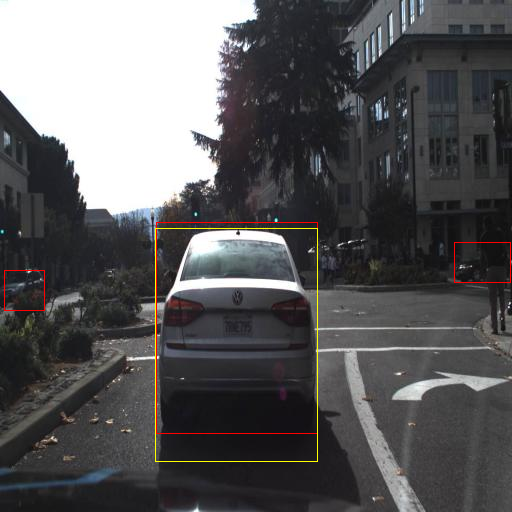

In [19]:
import statistics
import random
file_name = random.choice(os.listdir(sample_folder_size_labels))
print("File name: ", file_name)

truth_file = os.path.join(sample_folder_size_labels, file_name)
predict_file = os.path.join(sample_folder_predict, file_name)

with open(truth_file, "r") as file:
    # Read the entire content of the file
    content = file.read()
    # Print the content
    print("Truth label file")
    print(content)

with open(predict_file, "r") as file:
    # Read the entire content of the file
    content = file.read()
    # Print the content
    print("Predict label file")
    print(content)


print("IoU boxes percentage: ", calculate_multiple_iou(truth_file,predict_file,2 ))
print("Average: ",statistics.mean(calculate_multiple_iou(truth_file,predict_file,2 )))
      
#Tonen van bounding boxes rond de auto's op 1 willekeurig gekozen image
#Auto's zijn class_id 1 in de truth label-file en class_id 2 in de predict label-file
#vervangen door https://stackoverflow.com/questions/23720875/opencv-draw-a-rectangle-around-a-region
import cv2
from PIL import Image, ImageDraw

# Load the image
image = Image.open(os.path.join(sample_folder_size_images, os.path.splitext(file_name)[0] + ".jpg"))
draw = ImageDraw.Draw(image)

print(file_name)
# Load corresponding truth-label file
with open(os.path.join(sample_folder_size_labels, file_name), 'r') as f:
    lines = f.readlines()
    
# Parse bounding box data and draw on the image
for line in lines:
    class_id, x_center, y_center, width, height = map(float, line.strip().split())
    #class id 1 are cars,
    if class_id == 2:
        width *= image.width
        height *= image.height
        x_center *= image.width
        y_center *= image.height
        x_min = x_center - width / 2
        y_min = y_center - height / 2
        x_max = x_center + width / 2
        y_max = y_center + height / 2

        # Draw bounding box on the image
        draw.rectangle([x_min, y_min, x_max, y_max], outline="red")

print ("")
# Load corresponding predict-label file
with open(os.path.join(sample_folder_predict, file_name), 'r') as f:
    lines = f.readlines()

# Read label file and draw bounding boxes
for line in lines:
  class_id, x_center, y_center, width, height = map(float, line.strip().split())
  if class_id == 2:
      width *= image.width
      height *= image.height
      x_center *= image.width
      y_center *= image.height
      x_min = x_center - width / 2
      y_min = y_center - height / 2
      x_max = x_center + width / 2
      y_max = y_center + height / 2

      # Draw bounding box on the image
      draw.rectangle([x_min, y_min, x_max, y_max], outline="yellow")
# Show the image with bounding boxes
print("truth box rood")
print("predict box geel")
display(image)

#### 2.2.2 Autotellingen-resultaten van predictie YoloV8 model op 1 beeld

File name:  1478021935590284075_jpg.rf.83d49c1a59978615a09486d82ed20c55.txt
code vanuit truth-labels-file
2 0.087890625 0.54296875 0.1748046875 0.181640625

2 0.392578125 0.5078125 0.177734375 0.115234375

2 0.48828125 0.4853515625 0.0556640625 0.05859375

2 0.5419921875 0.4814453125 0.0595703125 0.06640625

2 0.61328125 0.4716796875 0.03515625 0.033203125

2 0.6494140625 0.4716796875 0.033203125 0.0400390625

2 0.7451171875 0.4765625 0.0625 0.056640625

2 0.8486328125 0.46484375 0.04296875 0.04296875

2 0.8955078125 0.466796875 0.0498046875 0.0498046875

2 0.9521484375 0.46484375 0.0732421875 0.056640625

2 0.962890625 0.4697265625 0.072265625 0.0537109375

truth box rood
predict box geel


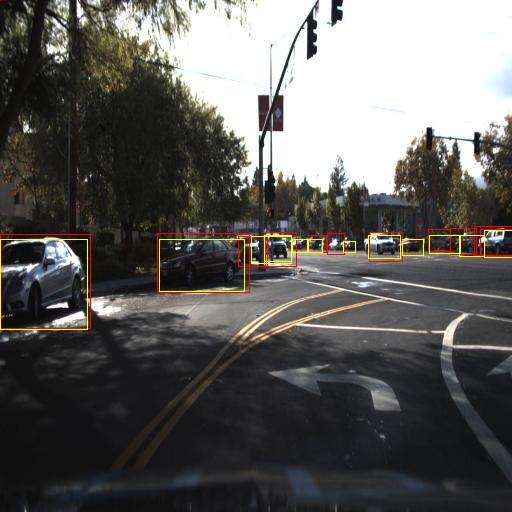

code vanuit predict-labels-file
2 0.0846191 0.549402 0.169213 0.172737

2 0.389649 0.512146 0.163278 0.0996696

9 0.609589 0.0652134 0.0248856 0.103198

2 0.74222 0.476552 0.0625868 0.0442685

2 0.579629 0.474876 0.0298138 0.0233284

9 0.658296 0.0246819 0.022648 0.0493639

2 0.967156 0.470402 0.0633234 0.0524444

9 0.84076 0.269716 0.0178528 0.043843

2 0.91147 0.474354 0.0472279 0.0397305

2 0.797098 0.477004 0.0402529 0.0311078

2 0.674428 0.476684 0.0240949 0.0209358

9 0.931412 0.281772 0.0163468 0.0523129

2 0.609224 0.474853 0.0277334 0.0243469

2 0.524155 0.482313 0.0785063 0.053134

2 0.859402 0.471874 0.0607586 0.0354481

2 0.537016 0.480063 0.0517958 0.0502957

aantal auto's truth 11.
aantal auto's predict 12.
percentage herkende auto's: 1.0909090909090908


In [20]:
import os

file_name = random.choice(os.listdir(sample_folder_size_labels))
print("File name: ", file_name)

truth_file = os.path.join(sample_folder_size_labels, file_name)
predict_file = os.path.join(sample_folder_predict, file_name)

# Load and print label files
with open(truth_file, 'r') as f:
    lines = f.readlines()
    print("code vanuit truth-labels-file")
    for line in lines:
      print(line)

print("truth box rood")
print("predict box geel")

#display image
image = Image.open(os.path.join(bounding_box_folder , os.path.splitext(file_name)[0] + ".jpg"))
display(image)

with open(predict_file, 'r') as f:
    lines = f.readlines()
    print("code vanuit predict-labels-file")
    for line in lines:
      print(line)

truth_number_cars= calculateNumberOfCars(truth_file,[2])
predict_number_cars = calculateNumberOfCars(predict_file,[2])

print(f"aantal auto's truth {truth_number_cars}.")
print(f"aantal auto's predict {predict_number_cars}.")
print("percentage herkende auto's:", predict_number_cars/truth_number_cars)

### 2.2.3 Benchmarks aanmaken over alle datasets met YOLOv8 predict

Eerst de predict functie laten lopen over alle beelden heen van de 6 datasets

In [21]:
# Process each image file
# wegschrijven resultaten in Yolo_output/predict folders
# inhoud results zie https://docs.ultralytics.com/reference/engine/results/#ultralytics.engine.results.BaseTensor.to

folder_path = os.path.join(training_sets_folder, "ongewijzigd/onder_de_grens")
project_path = os.path.join(sample_folder_size, "Yolo_output","predict","ongewijzigd/onder_de_grens")
model.predict(source=folder_path, save_txt = True, exist_ok=True, project=project_path, name="predict")

folder_path = os.path.join(training_sets_folder, "ongewijzigd/boven_de_grens")
project_path = os.path.join(sample_folder_size, "Yolo_output","predict","ongewijzigd/boven_de_grens")
model.predict(source=folder_path, save_txt = True, exist_ok=True, project=project_path, name="predict")

folder_path = os.path.join(training_sets_folder, "lichte_augmentatie/onder_de_grens")
project_path = os.path.join(sample_folder_size, "Yolo_output","predict","lichte_augmentatie/onder_de_grens")
model.predict(source=folder_path, save_txt = True, exist_ok=True, project=project_path, name="predict")

folder_path = os.path.join(training_sets_folder, "lichte_augmentatie/boven_de_grens")
project_path = os.path.join(sample_folder_size, "Yolo_output","predict","lichte_augmentatie/boven_de_grens")
model.predict(source=folder_path, save_txt = True, exist_ok=True, project=project_path, name="predict")

folder_path = os.path.join(training_sets_folder, "zware_augmentatie/onder_de_grens")
project_path = os.path.join(sample_folder_size, "Yolo_output","predict","zware_augmentatie/onder_de_grens")
model.predict(source=folder_path, save_txt = True, exist_ok=True, project=project_path, name="predict")

folder_path = os.path.join(training_sets_folder, "zware_augmentatie/boven_de_grens")
project_path = os.path.join(sample_folder_size, "Yolo_output","predict","zware_augmentatie/boven_de_grens")
model.predict(source=folder_path, save_txt = True, exist_ok=True, project=project_path, name="predict")

NameError: name 'model' is not defined

### 2.2.3.1 IoU Benchmarks

In [8]:
import pandas as pd
truth_path = os.path.join(training_sets_folder, "ongewijzigd/onder_de_grens")
predict_path = os.path.join(sample_folder_size, "Yolo_output","predict","ongewijzigd/onder_de_grens/predict/labels")
IOU_benchmark_ongewijzigd_onder_de_grens = calculate_IoU_Percentage(truth_path,predict_path,2)
print(IOU_benchmark_ongewijzigd_onder_de_grens)
# Find the tuple with the maximum second value
max_value_tuple = max(IOU_benchmark_ongewijzigd_onder_de_grens, key=lambda x: x[1])

# Print the result
print("Tuple with the maximum second value:", max_value_tuple)

# Create DataFrame for plotting and reference
df_IOU_benchmark_ongewijzigd_onder_de_grens= pd.DataFrame()
df_IOU_benchmark_ongewijzigd_onder_de_grens = pd.DataFrame(IOU_benchmark_ongewijzigd_onder_de_grens, columns=['ID', 'Percentage'])
df_IOU_benchmark_ongewijzigd_onder_de_grens['Benchmark'] = "IOU_ongewijzigd_onder_de_grens"

truth_path = os.path.join(training_sets_folder, "ongewijzigd/boven_de_grens")
predict_path = os.path.join(sample_folder_size, "Yolo_output","predict","ongewijzigd/boven_de_grens/predict/labels")
IOU_benchmark_ongewijzigd_boven_de_grens = calculate_IoU_Percentage(truth_path,predict_path,2)
# Create DataFrame for plotting and reference
df_IOU_benchmark_ongewijzigd_boven_de_grens= pd.DataFrame()
df_IOU_benchmark_ongewijzigd_boven_de_grens = pd.DataFrame(IOU_benchmark_ongewijzigd_boven_de_grens, columns=['ID', 'Percentage'])
df_IOU_benchmark_ongewijzigd_boven_de_grens['Benchmark'] = "IOU_ongewijzigd_boven_de_grens"

truth_path = os.path.join(training_sets_folder, "lichte_augmentatie/onder_de_grens")
predict_path = os.path.join(sample_folder_size, "Yolo_output","predict","lichte_augmentatie/onder_de_grens/predict/labels")
IOU_benchmark_lichte_augmentatie_onder_de_grens = calculate_IoU_Percentage(truth_path,predict_path,2)
# Create DataFrame for plotting and reference
df_IOU_benchmark_lichte_augmentatie_onder_de_grens= pd.DataFrame()
df_IOU_benchmark_lichte_augmentatie_onder_de_grens = pd.DataFrame(IOU_benchmark_lichte_augmentatie_onder_de_grens, columns=['ID', 'Percentage'])
df_IOU_benchmark_lichte_augmentatie_onder_de_grens['Benchmark'] = "IOU_lichte_augmentatie_onder_de_grens"

truth_path = os.path.join(training_sets_folder, "lichte_augmentatie/boven_de_grens")
predict_path = os.path.join(sample_folder_size, "Yolo_output","predict","lichte_augmentatie/boven_de_grens/predict/labels")
IOU_benchmark_lichte_augmentatie_boven_de_grens = calculate_IoU_Percentage(truth_path,predict_path,2)
# Create DataFrame for plotting and reference
df_IOU_benchmark_lichte_augmentatie_boven_de_grens= pd.DataFrame()
df_IOU_benchmark_lichte_augmentatie_boven_de_grens = pd.DataFrame(IOU_benchmark_lichte_augmentatie_boven_de_grens, columns=['ID', 'Percentage'])
df_IOU_benchmark_lichte_augmentatie_boven_de_grens['Benchmark'] = "IOU_lichte_augmentatie_boven_de_grens"

truth_path = os.path.join(training_sets_folder, "zware_augmentatie/onder_de_grens")
predict_path = os.path.join(sample_folder_size, "Yolo_output","predict","zware_augmentatie/onder_de_grens/predict/labels")
IOU_benchmark_zware_augmentatie_onder_de_grens = calculate_IoU_Percentage(truth_path,predict_path,2)
# Create DataFrame for plotting and reference
df_IOU_benchmark_zware_augmentatie_onder_de_grens= pd.DataFrame()
df_IOU_benchmark_zware_augmentatie_onder_de_grens = pd.DataFrame(IOU_benchmark_zware_augmentatie_onder_de_grens, columns=['ID', 'Percentage'])
df_IOU_benchmark_zware_augmentatie_onder_de_grens['Benchmark'] = "IOU_zware_augmentatie_onder_de_grens"


truth_path = os.path.join(training_sets_folder, "zware_augmentatie/boven_de_grens")
predict_path = os.path.join(sample_folder_size, "Yolo_output","predict","zware_augmentatie/boven_de_grens/predict/labels")
IOU_benchmark_zware_augmentatie_boven_de_grens = calculate_IoU_Percentage(truth_path,predict_path,2)
# Create DataFrame for plotting and reference
df_IOU_benchmark_zware_augmentatie_boven_de_grens= pd.DataFrame()
df_IOU_benchmark_zware_augmentatie_boven_de_grens = pd.DataFrame(IOU_benchmark_zware_augmentatie_boven_de_grens, columns=['ID', 'Percentage'])
df_IOU_benchmark_zware_augmentatie_boven_de_grens['Benchmark'] = "IOU_zware_augmentatie_boven_de_grens"


df_IOU_benchmark= pd.DataFrame()
df_IOU_benchmark = pd.concat([df_IOU_benchmark_ongewijzigd_onder_de_grens, df_IOU_benchmark_ongewijzigd_boven_de_grens,
                          df_IOU_benchmark_lichte_augmentatie_onder_de_grens, df_IOU_benchmark_lichte_augmentatie_boven_de_grens,
                          df_IOU_benchmark_zware_augmentatie_onder_de_grens, df_IOU_benchmark_zware_augmentatie_boven_de_grens], ignore_index=True)

[(1, 0), (2, 0), (3, 0), (4, 0.6846460210766862), (5, 0), (6, 0.38549688506247615), (7, 0.3435289337345512), (8, 0.0), (9, 0.46199151042284264), (10, 0.24131723593658488), (11, 0), (12, 0.3888314425121905), (13, 0.706755066988337), (14, 0), (15, 0.0), (16, 0.37761171631738066), (17, 0.40249059837992324), (18, 0.1520639480080347), (19, 0.0), (20, 0), (21, 0), (22, 0.38176631522108445), (23, 0), (24, 0.8728861057635665), (25, 0.647778465140372), (26, 0.18968854415382963), (27, 0), (28, 0), (29, 0.5450321986976114), (30, 0.4138716279429028), (31, 0.0), (32, 0.645863272340044), (33, 0.7493003724841087), (34, 0), (35, 0.7706939305814275), (36, 4.424557051965562), (37, 0), (38, 0), (39, 0.47527467912525745), (40, 0.8717373482057965), (41, 0.3946374984235594), (42, 0.32611885130342516), (43, 0.8453572971650998), (44, 0.8463041394162365), (45, 0), (46, 0.4018200872619074), (47, 0.7891829869890393), (48, 0.6078473747526841), (49, 0.8000396454620686), (50, 0.21170018055820902), (51, 0.6357874321

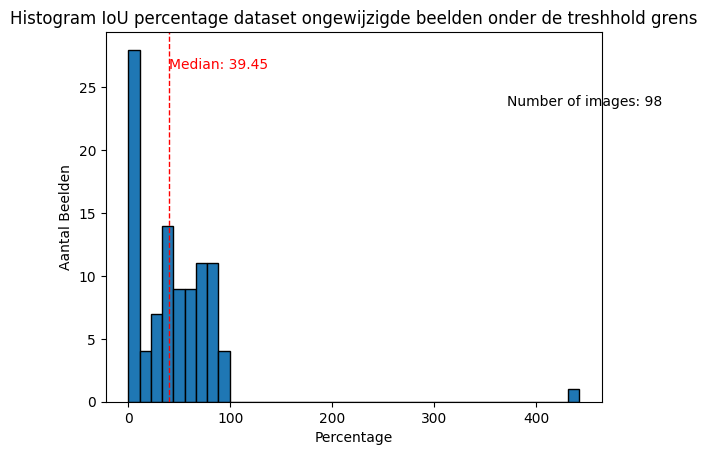

In [9]:
import matplotlib.pyplot as plt

# Specify number of bins for the histogram
num_bins = 40

# Plot histogram
plt.hist(df_IOU_benchmark_ongewijzigd_onder_de_grens['Percentage'] * 100, bins=num_bins, edgecolor='black')

# Calculate median
median_percentage = (df_IOU_benchmark_ongewijzigd_onder_de_grens['Percentage']* 100).median()

# Add vertical line for median
plt.axvline(median_percentage, color='red', linestyle='dashed', linewidth=1)

# Add labels and title
plt.xlabel('Percentage')
plt.ylabel('Aantal Beelden')
plt.title('Histogram IoU percentage dataset ongewijzigde beelden onder de treshhold grens')

# Show median value
plt.text(median_percentage, plt.ylim()[1]*0.9, f'Median: {median_percentage:.2f}', color='red')

# Calculate number of unique IDs
num_unique_ids = df_IOU_benchmark_ongewijzigd_onder_de_grens['ID'].nunique()

# Add legend
plt.text(plt.xlim()[1]*0.8, plt.ylim()[1]*0.8, f'Number of images: {num_unique_ids}', fontsize=10)

# Show plot
plt.show()


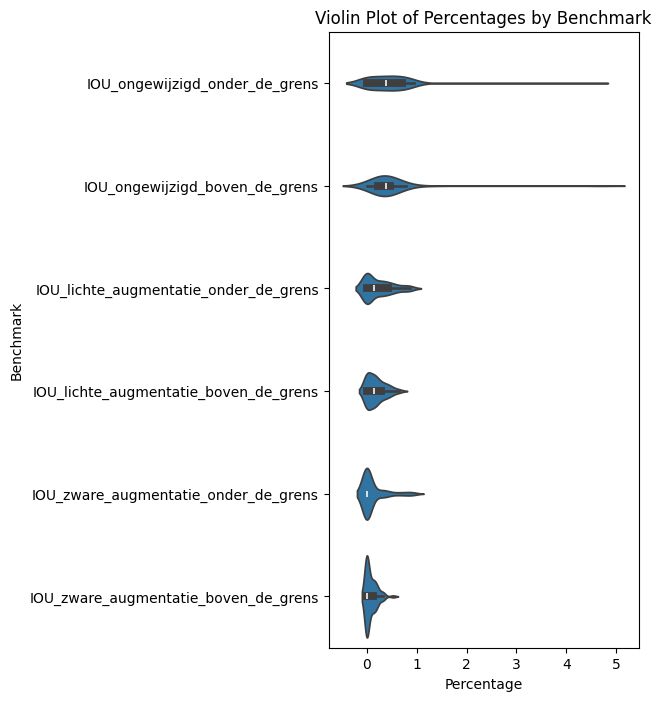

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Box Plot
#plt.figure(figsize=(6, 12))
#sns.boxplot(y='Benchmark', x='Percentage', data=df_benchmark)
#plt.ylabel('Benchmark')
#plt.xlabel('Percentage')
#plt.title('Box Plot of Percentages by Benchmark')
#plt.yticks(rotation=0)  # No need to rotate y-axis labels typically
#plt.show()

# Violin Plot ==> It shows the median, quartiles, and potential outliers. but also shows the density of the data at 
# different values. This can provide more insight into the distribution.
plt.figure(figsize=(4, 8))
sns.violinplot(y='Benchmark', x='Percentage', data=df_IOU_benchmark)
plt.ylabel('Benchmark')
plt.xlabel('Percentage')
plt.title('Violin Plot of Percentages by Benchmark')
plt.yticks(rotation=0)  # No need to rotate y-axis labels typically
plt.show()

# Strip Plot
#plt.figure(figsize=(6, 12))
#sns.stripplot(y='Benchmark', x='Percentage', data=df_benchmark, jitter=True)
#plt.ylabel('Benchmark')
#plt.xlabel('Percentage')
#plt.title('Strip Plot of Percentages by Benchmark')
#plt.yticks(rotation=0)  # No need to rotate y-axis labels typically
#plt.show()

# Bar Plot of Means with Error Bars
#means = df_benchmark.groupby('Benchmark')['Percentage'].mean()
#stds = df_benchmark.groupby('Benchmark')['Percentage'].std()

#plt.figure(figsize=(6, 12))
#means.plot(kind='barh', xerr=stds, capsize=4, color='skyblue', edgecolor='black')
#plt.ylabel('Benchmark')
#plt.xlabel('Mean Percentage')
#plt.title('Mean Percentage by Benchmark with Error Bars')
#plt.yticks(rotation=0)  # No need to rotate y-axis labels typically
#plt.show()


### 2.2.3.2 NDC Benchmarks

In [16]:
import pandas as pd
truth_path = os.path.join(training_sets_folder, "ongewijzigd/onder_de_grens")
predict_path = os.path.join(sample_folder_size, "Yolo_output","predict","ongewijzigd/onder_de_grens/predict/labels")
NDC_benchmark_ongewijzigd_onder_de_grens = calculateCarPercentage(truth_path,predict_path,[2])
# Create DataFrame for plotting and reference
df_NDC_benchmark_ongewijzigd_onder_de_grens= pd.DataFrame()
df_NDC_benchmark_ongewijzigd_onder_de_grens = pd.DataFrame(NDC_benchmark_ongewijzigd_onder_de_grens, columns=['ID', 'Percentage'])
df_NDC_benchmark_ongewijzigd_onder_de_grens['Benchmark'] = "NDC_ongewijzigd_onder_de_grens"

truth_path = os.path.join(training_sets_folder, "ongewijzigd/boven_de_grens")
predict_path = os.path.join(sample_folder_size, "Yolo_output","predict","ongewijzigd/boven_de_grens/predict/labels")
NDC_benchmark_ongewijzigd_boven_de_grens = calculateCarPercentage(truth_path,predict_path,[2])
# Create DataFrame for plotting and reference
df_NDC_benchmark_ongewijzigd_boven_de_grens= pd.DataFrame()
df_NDC_benchmark_ongewijzigd_boven_de_grens = pd.DataFrame(NDC_benchmark_ongewijzigd_boven_de_grens, columns=['ID', 'Percentage'])
df_NDC_benchmark_ongewijzigd_boven_de_grens['Benchmark'] = "NDC_ongewijzigd_boven_de_grens"

truth_path = os.path.join(training_sets_folder, "lichte_augmentatie/onder_de_grens")
predict_path = os.path.join(sample_folder_size, "Yolo_output","predict","lichte_augmentatie/onder_de_grens/predict/labels")
NDC_benchmark_lichte_augmentatie_onder_de_grens = calculateCarPercentage(truth_path,predict_path,[2])
# Create DataFrame for plotting and reference
df_NDC_benchmark_lichte_augmentatie_onder_de_grens= pd.DataFrame()
df_NDC_benchmark_lichte_augmentatie_onder_de_grens = pd.DataFrame(NDC_benchmark_lichte_augmentatie_onder_de_grens, columns=['ID', 'Percentage'])
df_NDC_benchmark_lichte_augmentatie_onder_de_grens['Benchmark'] = "NDC_lichte_augmentatie_onder_de_grens"

truth_path = os.path.join(training_sets_folder, "lichte_augmentatie/boven_de_grens")
predict_path = os.path.join(sample_folder_size, "Yolo_output","predict","lichte_augmentatie/boven_de_grens/predict/labels")
NDC_benchmark_lichte_augmentatie_boven_de_grens = calculateCarPercentage(truth_path,predict_path,[2])
# Create DataFrame for plotting and reference
df_NDC_benchmark_lichte_augmentatie_boven_de_grens= pd.DataFrame()
df_NDC_benchmark_lichte_augmentatie_boven_de_grens = pd.DataFrame(NDC_benchmark_lichte_augmentatie_boven_de_grens, columns=['ID', 'Percentage'])
df_NDC_benchmark_lichte_augmentatie_boven_de_grens['Benchmark'] = "NDC_lichte_augmentatie_boven_de_grens"

truth_path = os.path.join(training_sets_folder, "zware_augmentatie/onder_de_grens")
predict_path = os.path.join(sample_folder_size, "Yolo_output","predict","zware_augmentatie/onder_de_grens/predict/labels")
NDC_benchmark_zware_augmentatie_onder_de_grens = calculateCarPercentage(truth_path,predict_path,[2])
# Create DataFrame for plotting and reference
df_NDC_benchmark_zware_augmentatie_onder_de_grens= pd.DataFrame()
df_NDC_benchmark_zware_augmentatie_onder_de_grens = pd.DataFrame(NDC_benchmark_zware_augmentatie_onder_de_grens, columns=['ID', 'Percentage'])
df_NDC_benchmark_zware_augmentatie_onder_de_grens['Benchmark'] = "NDC_zware_augmentatie_onder_de_grens"


truth_path = os.path.join(training_sets_folder, "zware_augmentatie/boven_de_grens")
predict_path = os.path.join(sample_folder_size, "Yolo_output","predict","zware_augmentatie/boven_de_grens/predict/labels")
NDC_benchmark_zware_augmentatie_boven_de_grens = calculateCarPercentage(truth_path,predict_path,[2])
# Create DataFrame for plotting and reference
df_NDC_benchmark_zware_augmentatie_boven_de_grens= pd.DataFrame()
df_NDC_benchmark_zware_augmentatie_boven_de_grens = pd.DataFrame(NDC_benchmark_zware_augmentatie_boven_de_grens, columns=['ID', 'Percentage'])
df_NDC_benchmark_zware_augmentatie_boven_de_grens['Benchmark'] = "NDC_zware_augmentatie_boven_de_grens"

df_NDC_benchmark= pd.DataFrame()
df_NDC_benchmark = pd.concat([df_NDC_benchmark_ongewijzigd_onder_de_grens, df_NDC_benchmark_ongewijzigd_boven_de_grens,
                          df_NDC_benchmark_lichte_augmentatie_onder_de_grens, df_NDC_benchmark_lichte_augmentatie_boven_de_grens,
                          df_NDC_benchmark_zware_augmentatie_onder_de_grens, df_NDC_benchmark_zware_augmentatie_boven_de_grens], ignore_index=True)

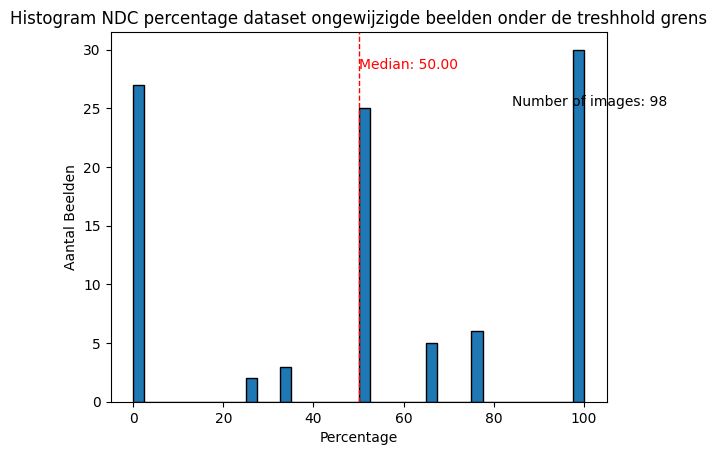

In [17]:
import matplotlib.pyplot as plt

# Specify number of bins for the histogram
num_bins = 40

# Plot histogram
plt.hist(df_NDC_benchmark_ongewijzigd_onder_de_grens['Percentage'] * 100, bins=num_bins, edgecolor='black')

# Calculate median
median_percentage = (df_NDC_benchmark_ongewijzigd_onder_de_grens['Percentage']* 100).median()

# Add vertical line for median
plt.axvline(median_percentage, color='red', linestyle='dashed', linewidth=1)

# Add labels and title
plt.xlabel('Percentage')
plt.ylabel('Aantal Beelden')
plt.title('Histogram NDC percentage dataset ongewijzigde beelden onder de treshhold grens')

# Show median value
plt.text(median_percentage, plt.ylim()[1]*0.9, f'Median: {median_percentage:.2f}', color='red')

# Calculate number of unique IDs
num_unique_ids = df_NDC_benchmark_ongewijzigd_onder_de_grens['ID'].nunique()

# Add legend
plt.text(plt.xlim()[1]*0.8, plt.ylim()[1]*0.8, f'Number of images: {num_unique_ids}', fontsize=10)

# Show plot
plt.show()


De mediaan is 50% herkenning
In 30 beelden is er perfecte herkenning
In 27 beelden worden er niets herkend

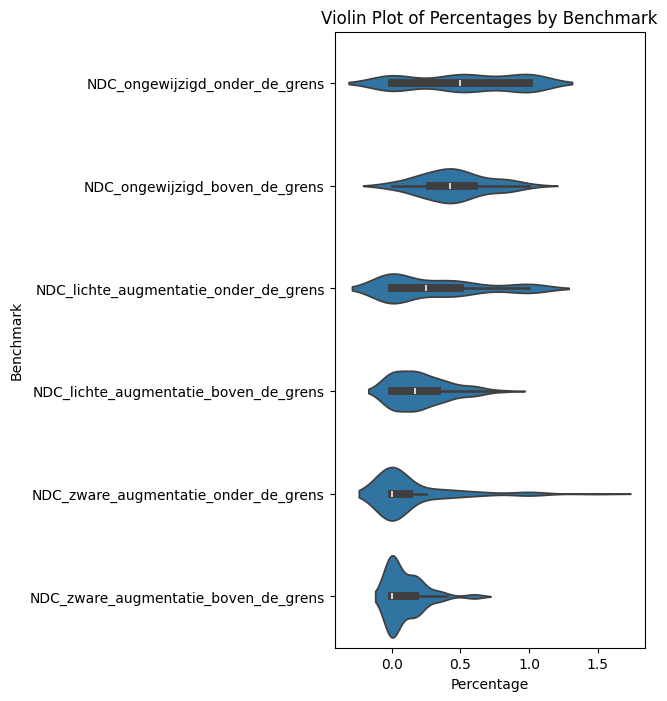

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Box Plot
#plt.figure(figsize=(6, 12))
#sns.boxplot(y='Benchmark', x='Percentage', data=df_NDC_benchmark)
#plt.ylabel('Benchmark')
#plt.xlabel('Percentage')
#plt.title('Box Plot of Percentages by Benchmark')
#plt.yticks(rotation=0)  # No need to rotate y-axis labels typically
#plt.show()

# Violin Plot ==> It shows the median, quartiles, and potential outliers. but also shows the density of the data at 
# different values. This can provide more insight into the distribution.
plt.figure(figsize=(4, 8))
sns.violinplot(y='Benchmark', x='Percentage', data=df_NDC_benchmark)
plt.ylabel('Benchmark')
plt.xlabel('Percentage')
plt.title('Violin Plot of Percentages by Benchmark')
plt.yticks(rotation=0)  # No need to rotate y-axis labels typically
plt.show()

# Strip Plot
#plt.figure(figsize=(6, 12))
#sns.stripplot(y='Benchmark', x='Percentage', data=df_NDC_benchmark, jitter=True)
#plt.ylabel('Benchmark')
#plt.xlabel('Percentage')
#plt.title('Strip Plot of Percentages by Benchmark')
#plt.yticks(rotation=0)  # No need to rotate y-axis labels typically
#plt.show()

# Bar Plot of Means with Error Bars
#means = df_NDC_benchmark.groupby('Benchmark')['Percentage'].mean()
#stds = df_NDC_benchmark.groupby('Benchmark')['Percentage'].std()

#plt.figure(figsize=(6, 12))
#means.plot(kind='barh', xerr=stds, capsize=4, color='skyblue', edgecolor='black')
#plt.ylabel('Benchmark')
#plt.xlabel('Mean Percentage')
#plt.title('Mean Percentage by Benchmark with Error Bars')
#plt.yticks(rotation=0)  # No need to rotate y-axis labels typically
#plt.show()


# 3 Training

In [29]:
#aanmaken van de training, validatie en test-folders voor alle datasets 
# Aanmaken folders
target_folders = ["images", "labels"]
sub_target_folders = ["train", "val","test"]

# Function to create folders if they don't exist
def create_folders(training_sets_folder):
    for folder in target_folders:
        folder_path = os.path.join(training_sets_folder, folder)
        if not os.path.exists(folder_path):
            for subfolder in sub_target_folders:
                sub_folder_path = os.path.join(folder_path, subfolder)
                os.makedirs(sub_folder_path)

# Create target folders
create_folders(os.path.join(training_sets_folder, "ongewijzigd/onder_de_grens"))
create_folders(os.path.join(training_sets_folder, "ongewijzigd/boven_de_grens"))
create_folders(os.path.join(training_sets_folder, "lichte_augmentatie/onder_de_grens"))
create_folders(os.path.join(training_sets_folder, "lichte_augmentatie/boven_de_grens"))
create_folders(os.path.join(training_sets_folder, "zware_augmentatie/onder_de_grens"))
create_folders(os.path.join(training_sets_folder, "zware_augmentatie/boven_de_grens"))

In [30]:
#aanpassen van de class_id's in de label-files want in de Yaml-file van het model 
#staat maar 1 klasse (we detecteren enkel auto's), dus deze klasse moet 0 zijn 

import os

# Function to update class IDs
def update_class_ids(label_file):
    updated_lines = []
    with open(label_file, 'r') as file:
        lines = file.readlines()
        for line in lines:
            parts = line.strip().split()
            class_id = int(parts[0])
            if class_id == 2:
                parts[0] = '0'  # Update class_id from 1 to 2
                updated_lines.append(' '.join(parts) + '\n')

    with open(label_file, 'w') as file:
        file.writelines(updated_lines)

# Process all label files in the directory
def update_class_ids_folder(folder_path):
    # Get list of all label files in the predict folder
    label_txt_files = [f for f in os.listdir(folder_path)]
    for label_file in label_txt_files:
        file_path = os.path.join(folder_path, label_file)
        update_class_ids(file_path)

In [31]:
#80-10-10 split voor training-validation-test
from sklearn.model_selection import train_test_split
import os
import shutil

def splitten (path):
    # Get list of image files
    image_files = [os.path.join(path, f) for f in os.listdir(path) if f.endswith('.jpg')]
    # Split dataset into train, val, and test sets
    train_files, temp_files = train_test_split(image_files, test_size=0.2, random_state=42)
    val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42) 
    # Iterate through each image file
    for image_train_file in train_files:
        shutil.copy(image_train_file, os.path.join(path,"images/train"))
        shutil.copy(os.path.join(os.path.dirname(image_train_file),os.path.basename(image_train_file).replace('.jpg', '.txt')), os.path.join(path,"labels/train"))
        update_class_ids_folder(os.path.join(path,"labels/train"))
    for image_val_file in val_files:
        shutil.copy(image_val_file, os.path.join(path,"images/val"))
        shutil.copy(os.path.join(os.path.dirname(image_val_file),os.path.basename(image_val_file).replace('.jpg', '.txt')), os.path.join(path,"labels/val"))    
        update_class_ids_folder(os.path.join(path,"labels/val"))
    for image_test_file in test_files:
        shutil.copy(image_test_file, os.path.join(path,"images/test"))
        shutil.copy(os.path.join(os.path.dirname(image_test_file),os.path.basename(image_test_file).replace('.jpg', '.txt')), os.path.join(path,"labels/test"))
        update_class_ids_folder(os.path.join(path,"labels/test"))
            
splitten(os.path.join(training_sets_folder, "ongewijzigd/onder_de_grens"))
splitten(os.path.join(training_sets_folder, "ongewijzigd/boven_de_grens"))
splitten(os.path.join(training_sets_folder, "lichte_augmentatie/onder_de_grens"))
splitten(os.path.join(training_sets_folder, "lichte_augmentatie/boven_de_grens"))
splitten(os.path.join(training_sets_folder, "zware_augmentatie/onder_de_grens"))
splitten(os.path.join(training_sets_folder, "zware_augmentatie/boven_de_grens"))

## 3.1 Training van dataset 1: ongewijzigde beelden onder de treshhold grens

In [19]:
#import model
from IPython import display
display.clear_output()

import ultralytics
import os
ultralytics.checks()

from ultralytics import YOLO

from IPython.display import display, Image

model = YOLO('yolov8n.pt')

# Train the model
# https://docs.ultralytics.com/usage/cfg/#train-settings
# https://www.youtube.com/watch?v=LNwODJXcvt4&list=PL1FZnkj4ad1PFJTjW4mWpHZhzgJinkNV0&index=11
# https://www.youtube.com/watch?v=j8uQc0qB91s
# https://docs.ultralytics.com/modes/train/
# per training moet er een yaml-file voorzien worden
#  Model Tuning: The validation set is used during the training process to fine-tune the model
# De validatie-set staat aangeduid in de yaml file.
# uitleg over de validatie dataset in Yolo
# "The validation dataset doesn't directly affect the training process, as it's not used to update the model's weights. 
# During training, the model's parameters are updated based on the loss computed from the training dataset. 
# The validation dataset is used to evaluate the model's performance on unseen data without influencing the training updates.
#However, the validation dataset plays a crucial role in several passive aspects of the training process:
# -Model Selection: The validation dataset is used to select the best model during training. For example, you might save the model that achieves the highest accuracy or lowest loss on the validation set, which is a form of early stopping.
# -Hyperparameter Tuning: The performance of the model on the validation dataset is used to tune hyperparameters. If you adjust hyperparameters based on validation performance, this indirectly affects the training process.
# -Overfitting Detection: The validation dataset helps in detecting overfitting. If the model performs well on the training data but poorly on the validation data, it may be overfitting to the training data.
# -Stopping Criteria: The validation dataset can be used to implement stopping criteria for training, such as reducing the learning rate on a validation loss plateau or stopping training early if the validation loss starts to increase.
# -Confidence Calibration: The validation dataset can be used to calibrate the confidence of the model's predictions, which can be important for deployment

# Validation data is used during the model training process to tune the parameters (hyperparameters) of the model, 
# such as number of epochs, batch size, etc. It provides a way to assess the performance of the model during training 
# allowing you to make adjustments. By evaluating your model's performance on the validation set, you can determine how 
# well the model is learning and generalizing from the training data, adjust your learning rate, add regularization etc 
# to prevent overfitting or underfitting.

#Test data, on the other hand, is used after the model has been trained to evaluate how well the model will perform on 
#unseen data. This is the final evaluation step before deploying a model for production use. The concept is to provide a 
# final, unbiased estimate of the model's capacity to generalize to new data.
# you can certainly evaluate your model on a test dataset. To do this, you would use the test command. This command will run an evaluation of your model on a 
# specified dataset and will generate various evaluation metrics including precision, recall, F1 score, and mAP among others.

results = model.train(data='./YAML/data_ongewijzigd_onder_de_grens.yaml', epochs=30,  imgsz=512) 
#task is default detect so not mentioned

#wanneer hertrainen? Wanneer is het model goed genoeg? https://www.youtube.com/watch?v=q7LwPoM7tSQ

Ultralytics YOLOv8.0.196  Python-3.12.3 torch-2.3.0+cpu CPU (Intel Core(TM) i9-9900K 3.60GHz)
Setup complete  (16 CPUs, 31.9 GB RAM, 348.0/475.7 GB disk)
New https://pypi.org/project/ultralytics/8.2.28 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.196  Python-3.12.3 torch-2.3.0+cpu CPU (Intel Core(TM) i9-9900K 3.60GHz)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=data_ongewijzigd_onder_de_grens.yaml, epochs=30, patience=50, batch=16, imgsz=512, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, sa

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0
                   all         10          1   0.000333          1    0.00063   0.000315

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      28/30         0G     0.2226      31.21      0.186          0        512: 100%|██████████| 5/5 [00:09<00:00,  1.84
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0
                   all         10          1   0.000333          1    0.00063   0.000315

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      29/30         0G     0.4968      31.67     0.2065          0        512: 100%|██████████| 5/5 [00:09<00:00,  1.90
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0
                   all         10          1   0.000333         

In [21]:
NEXT STEPS - TODO
# Load the trained weights (komen in folder runs/train/weights/) -- welke kiezen???
model = YOLO('runs/train/weights/best.pt')

# test set laten lopen ==>
# testing gebeurt via model.val (ietwat ongelukkig gekozen door de ontwerpers, en maakt gebruik van de test-set aangeduid in de 
# yaml file)
# https://docs.ultralytics.com/modes/val/#introduction
# https://docs.ultralytics.com/modes/val/#arguments-for-yolo-model-validation
# The test set is used to evaluate the final model after it has been trained and validated. 
# It provides an unbiased estimate of model performance on unseen data.
# in YOLOv8, testing on a dataset is achieved by using the 'val' mode with your test data path. To clarify, there isn't a separate 'test' mode in the command line interface. 
#The 'val' mode is used to evaluate the model's performance against a specified dataset.
via model.val(data='./YAML/data_ongewijzigd_onder_de_grens.yaml', epochs=30,  imgsz=512) 

#https://docs.ultralytics.com/modes/#predict
via model.predict(data='./YAML/data_ongewijzigd_onder_de_grens.yaml', epochs=30,  imgsz=512)

#met de laatste predict-resultaten de NDC en IOU berekenen 
#hiermee de histogram en violin plot tekenen voor de predicted test-set
#en deze NDC en IOU afzetten tov de benchmark (side by side, maar welke grafiek)???
# wat staat er nog allemaal in de folder runs/train en hoe dit te interpreteren? Er staat bvb. MAP in, F1, ...
# https://www.youtube.com/watch?v=q7LwPoM7tSQ

SyntaxError: invalid syntax (3052396197.py, line 7)

TODO: 3.1 als het af is herhalen voor de rest van de datasets (nog 5 stuks) en conclusies trekken - gaan we erop vooruit bij steeds meer geaugmenteerde datasets?